# Logistic Regression Example - 逻辑回归示例

Logistic regression implementation with TensorFlow v2 library.
使用 TensorFlow v2 库实现逻辑回归。

This example is using a low-level approach to better understand all mechanics behind the training process.
这个示例使用了一种低阶的方法来更好地理解训练过程背后的所有机制。

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## MNIST Dataset Overview - MNIST 数据集概述

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 
这个示例使用了 MNIST 手写数字图片数据集。该数据集包含 60000 个用于训练的示例和 10000 个用于测试的示例。这些数字图片的尺寸已经被标准化，以一个固定大小的图像（28x28 像素）并居中，灰度值从 0 到 255。

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

在这个示例中，每个图像将被转换为 float32 类型的数组，将其灰度值标准化到 [0, 1] 并展平为一个 784 个特征（28*28）的一维数组。

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [45]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import tensorflow.python.keras as keras # 译者注: 新版本的keras需要这样导入
import keras._tf_keras.keras.optimizers as optimizers


In [46]:
# MNIST dataset parameters. - MINIST数据集补充参数
num_classes = 10 # 0 to 9 digits - 0到9的数字，共10种
num_features = 784 # 28*28 - 特征数量，分辨率为28*28、共784个特征(像素点)

# Training parameters. - 训练超参数
learning_rate = 0.01 # 学习率
training_steps = 1000 # 训练步数
batch_size = 256 # 批次大小
display_step = 50 # 显示间隔

In [47]:
# Prepare MNIST data. - 准备MNIST数据
import keras.api.datasets.mnist as mnist # 译者注: 新版本的mnist数据集需要这样导入
(x_train, y_train), (x_test, y_test) = mnist.load_data() # 这里的Load方法返回两个元组，第一个元组包含训练数据和标签，第二个元组包含测试数据和标签,他们都是NDArray类型
# Convert to float32. - 转换为float32类型, MNIST数据集的数据类型是uint8(0~255的灰度)，我们将其转换为float32类型
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28). - 将图像二维数组展平为784个特征(28*28)一维数组
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1]. - 将图像灰度值从[0, 255]归一化到[0, 1]
x_train, x_test = x_train / 255., x_test / 255.

In [48]:
# Use tf.data API to shuffle and batch data. - 使用tf.data API来打乱和合批数据
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # 构建TensorFlow可以使用的数据集结构
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1) # 重复、打乱、合批数据
# 上面的Prefecth方法是为了提高数据读取的效率，它会在训练的同时预取数据，这样可以减少训练时的等待时间， 但是会占用更多的内存

In [49]:
# Weight of shape [784, 10], the 28*28 image features, and total number of classes.
# 定义权重变量，形状为[784, 10]，784是特征数量，10是类别数量
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# Bias of shape [10], the total number of classes.
# 定义偏置变量，形状为[10]，10是类别数量
b = tf.Variable(tf.zeros([num_classes]), name="bias")

# Logistic regression (Wx + b). - 逻辑回归模型
def logistic_regression(x):
    # Apply softmax to normalize the logits to a probability distribution.
    # 使用softmax函数将逻辑回归的输出归一化为概率分布
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function. - 交叉熵误差 损失函数
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector. - 将标签编码为one-hot向量，即正确的类别标签为1，其他为0
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error. - 为了避免log(0)错误，将预测值限制在1e-9到1之间
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy. - 计算交叉熵
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))
    # 公式：H(y) = -Σy_true * log(y_pred)   

# Accuracy metric. - 模型准确率评估
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    # 预测类别是预测向量中最高分数的索引(即argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer. - 随机梯度下降法，随机性体现在通过mini-batch来更新整体梯度
optimizer = optimizers.SGD(learning_rate)

In [50]:
# Optimization process.  - 反向传播优化过程
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    # 使用tf.GradientTape() 计算梯度
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)

    # Compute gradients. - 计算梯度
    gradients = g.gradient(loss, [W, b])
    
    # Update W and b following gradients. - 根据梯度更新W和b
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [51]:
# Run training for the given number of steps. - 运行给定步数的训练
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    # 运行优化函数更新W和b的值
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0: # 每隔指定的步数打印一次训练结果，可以明显观察到Loss值的下降和准确率的提升
        pred = logistic_regression(batch_x) # 前向传播得到预测值
        loss = cross_entropy(pred, batch_y) # 计算交叉熵损失
        acc = accuracy(pred, batch_y) # 评估模型准确率
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 1.863139, accuracy: 0.726562
step: 100, loss: 1.558034, accuracy: 0.769531
step: 150, loss: 1.355339, accuracy: 0.816406
step: 200, loss: 1.201921, accuracy: 0.804688
step: 250, loss: 1.030749, accuracy: 0.839844
step: 300, loss: 1.045298, accuracy: 0.792969
step: 350, loss: 0.919128, accuracy: 0.832031
step: 400, loss: 0.868659, accuracy: 0.820312
step: 450, loss: 0.739629, accuracy: 0.875000
step: 500, loss: 0.793308, accuracy: 0.839844
step: 550, loss: 0.721409, accuracy: 0.867188
step: 600, loss: 0.710276, accuracy: 0.867188
step: 650, loss: 0.749321, accuracy: 0.820312
step: 700, loss: 0.652804, accuracy: 0.875000
step: 750, loss: 0.790389, accuracy: 0.835938
step: 800, loss: 0.597450, accuracy: 0.902344
step: 850, loss: 0.630841, accuracy: 0.843750
step: 900, loss: 0.693279, accuracy: 0.828125
step: 950, loss: 0.590285, accuracy: 0.886719
step: 1000, loss: 0.582232, accuracy: 0.867188


In [52]:
# Test model on validation set. - 在验证集上测试模型
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.869700


In [53]:
# Visualize predictions. - 可视化预测结果
import matplotlib.pyplot as plt

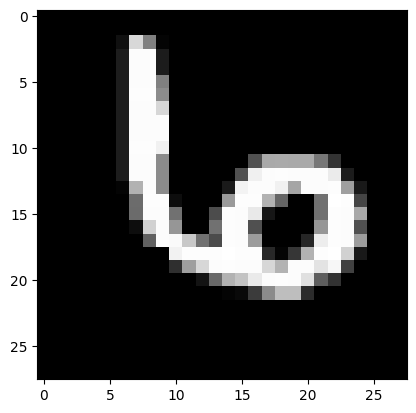

Model prediction: 6


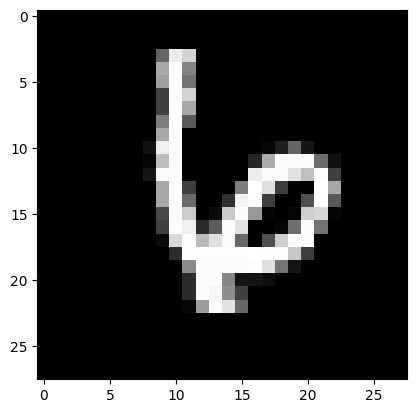

Model prediction: 6


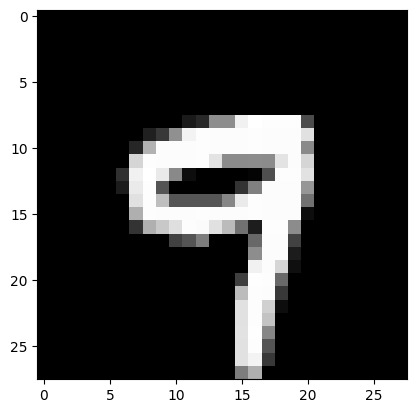

Model prediction: 4


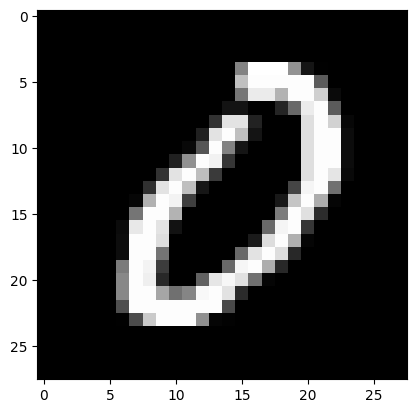

Model prediction: 0


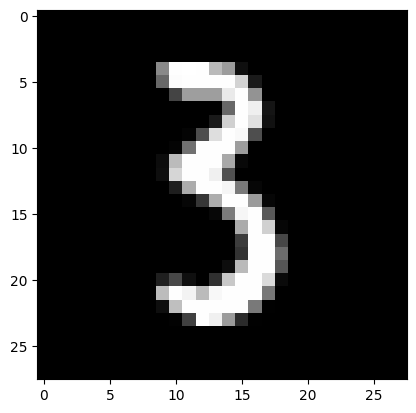

Model prediction: 3


In [54]:
# Predict 5 images from validation set. - 从验证集中随机找5张图片验证
n_images = 5
# test_images = x_test[:n_images] 译者注：这里原文是取前5张图片，我改成随机取5张图片，可能更有代表性
test_images = x_test[np.random.choice(x_test.shape[0], n_images, replace=False)]
predictions = logistic_regression(test_images)

# Display image and model prediction. - 显示图片和模型预测结果
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))